In [1]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
corpus = open("datasets/names.txt").read().splitlines()

In [7]:
corpus[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
#building the mappings like tokeniser
clean = sorted(set(''.join(corpus)))
stoi = {s:i for i,s in enumerate(clean)}
stoi['.'] = 26
itos = {i:s for s,i in stoi.items()}

In [44]:
#build the dataset 
block_size = 5
def build_dataset(current_corpus):
        X,Y = [], []
        context = [26] * block_size
        for word in current_corpus:
            word = list(word) + ['.']
            for ch1 in word:
                current = stoi[ch1]
                Y.append(current)
                X.append(context)
                #print(''.join(itos[i] for i in context), '--->', itos[current])
                context = context[1:] + [current]
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        return X,Y

import random
random.seed(32)
random.shuffle(corpus)
n1 = int(0.8 * len(corpus))
n2 = int(0.9 * len(corpus))
Xtrain, Ytrain = build_dataset(corpus[:n1])
Xval, Yval = build_dataset(corpus[n1:n2])
Xtest, Ytest = build_dataset(corpus[n2:])

In [45]:
block_size = 5
embedding_size = 8
batch_size = 32
fan_in = embedding_size * block_size
g = torch.Generator().manual_seed(2347243647)
C = torch.randn((27,embedding_size),generator=g)
w1 = torch.randn((fan_in, 200),generator=g) * 0.01
b1 = torch.randn((200),generator=g) * 0
w2 = torch.randn((200, 27),generator=g) * 0.01
b2 = torch.randn((27),generator=g) * 0
parameters = [C, w1, b1, w2, b2]

In [121]:
counts = logits.exp()      #logits increase to make counts
prob = counts / counts.sum(-1, keepdims=True) #counts normalized
manual_loss = -prob[torch.arange(413),Y].log().mean() #model product for all correct prob.trans

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [413], [228146]

In [46]:
count = 0
for p in parameters:
    count += p.nelement()
count

13843

In [47]:
for p in parameters:
    p.requires_grad = True

In [48]:
steps, lossi = [],[]

In [54]:
for i in range(20000):

  #generate a batch
  idx = torch.randint(0, Xtrain.shape[0], (batch_size,))
  
  #forward pass
  emb = C[Xtrain[idx]]
  hpreact = emb.view(-1,fan_in) @ w1 + b1
  h = torch.tanh(hpreact)
  logits = h @ w2 + b2
  step_loss = f.cross_entropy(logits,Ytrain[idx])

  #backward pass
  for p in parameters:
    p.grad = None
  step_loss.backward()

  #update
  #lr = 0.1 if i < 5000 else 0.01
  lr = 0.0001
  steps.append(i)
  lossi.append(step_loss.item())
  for p in parameters:
    p.data += -lr * p.grad
print(step_loss.item())

2.08855938911438


In [56]:
#loss for val set
with torch.no_grad():
    emb = C[Xval]
    hpreact = emb.view(-1,fan_in) @ w1 + b1
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    val_loss = f.cross_entropy(logits,Yval)
print(val_loss.item())

2.196312189102173


In [57]:
#loss for test set
with torch.no_grad():
    emb = C[Xtest]
    hpreact = emb.view(-1,fan_in) @ w1 + b1
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    test_loss = f.cross_entropy(logits,Ytest)
print(test_loss.item())

2.185667037963867


In [31]:
lossi[-10:]

[2.0653350353240967,
 2.1197354793548584,
 2.0838534832000732,
 2.0819685459136963,
 2.349792003631592,
 2.184760332107544,
 2.0282347202301025,
 2.101531982421875,
 2.200718402862549,
 2.2208456993103027]

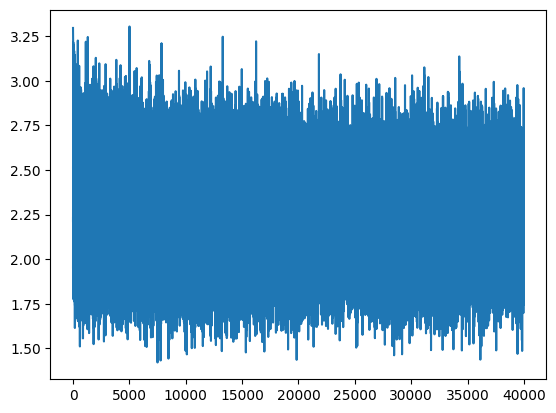

In [55]:
plt.plot(steps, lossi)

In [58]:
# sample from the model
g = torch.Generator().manual_seed(2147447+ 10)

for _ in range(50):
    out = []
    context = [26] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = f.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 26:
        break

    print(''.join(itos[i] for i in out))

pyanna.
havei.
comelah.
marina.
denora.
paisleah.
jrillyn.
rofanna.
cantbetton.
slanzaniyah.
ratsynon.
vakina.
axtel.
bevyron.
craylanna.
mhayari.
kree.
csana.
fuuler.
crrase.
halav.
fylaenna.
axdire.
bmily.
aclarake.
cilre.
lasron.
rrphice.
hrya.
dosciya.
bcormoni.
akaun.
kittir.
clebesa.
iuera.
kaubes.
safazilah.
hirthelice.
brimah.
rambra.
mary.
ceakleeth.
drysh.
wakayah.
eonaa.
covan.
qevynna.
ayneur.
vavlre.
blaeh.


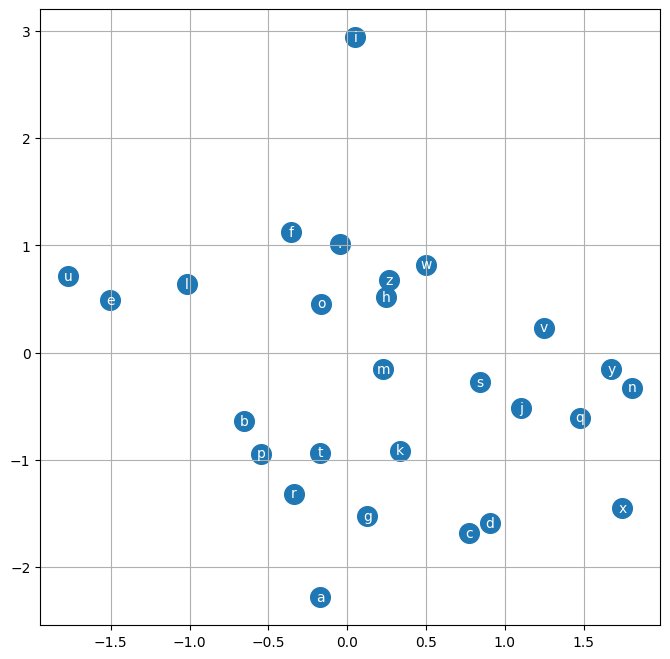

In [22]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')